In [0]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

### States that can be queried
There are in total 56 administrative regions in the USA. They are listed here below, where the dictionary `code2name` is defined with keys equal to the state codes (e.g. FL or NY) and the values are the corrisponding names of the states (Florida and New York for the previous examples).



In [2]:
USA_STATE_CODES = ['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE',
                   'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY',
                   'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT',
                   'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK',
                   'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
                   'VI', 'VT', 'WA', 'WI', 'WV', 'WY']

df = pd.read_json('https://covidtracking.com/api/v1/states/info.json')
code2name = {}
name2code = {}
for code in USA_STATE_CODES:
  name = df[df['state'] == code]['name'].values[0]
  code2name[code] = name
  name2code[name] = code
  print(code, name)

AK Alaska
AL Alabama
AR Arkansas
AS American Samoa
AZ Arizona
CA California
CO Colorado
CT Connecticut
DC District Of Columbia
DE Delaware
FL Florida
GA Georgia
GU Guam
HI Hawaii
IA Iowa
ID Idaho
IL Illinois
IN Indiana
KS Kansas
KY Kentucky
LA Louisiana
MA Massachusetts
MD Maryland
ME Maine
MI Michigan
MN Minnesota
MO Missouri
MP Northern Mariana Islands
MS Mississippi
MT Montana
NC North Carolina
ND North Dakota
NE Nebraska
NH New Hampshire
NJ New Jersey
NM New Mexico
NV Nevada
NY New York
OH Ohio
OK Oklahoma
OR Oregon
PA Pennsylvania
PR Puerto Rico
RI Rhode Island
SC South Carolina
SD South Dakota
TN Tennessee
TX Texas
UT Utah
VA Virginia
VI US Virgin Islands
VT Vermont
WA Washington
WI Wisconsin
WV West Virginia
WY Wyoming


# Database
The data in a single region are incapsulated as instances of the `RegionData` class defined in the forthcoming code cell. The object can be instantiated with the default initializator (see docstring) or by fetching the data from the COVID Tracking Project. In this case, it is possible to specify the state for which the database is going to be fetched or data for the whole USA can be selected. The database can be represented as a Pandas dataframe or as Numpy arrays.

Examples will be shown after the definition of the class.

In [0]:
class RegionData():
  def __init__(self, name, code, dates, cases):
    self._name = str(name)
    self._code = str(code)

    if len(dates) != np.unique(dates).size:
      raise ValueError('Values of `dates` are not unique.')
    if len(dates) != len(cases):
      raise ValueError('`dates` and `cases` must have the same length.')

    self._dates = np.asarray(dates)
    self._cases = np.asarray(cases).astype(np.int32)

  @property
  def name(self):
    return self._name
  
  @property
  def cases(self):
    return self._cases

  @property
  def code(self):
    return self._code
  
  @property
  def dates(self):
    return self._dates
  
  @property
  def asdf(self):
    """Return the data as a Pandas DataFrame object."""
    frame = {}
    frame['dates'] = self.dates
    frame['cases'] = self.cases
    return pd.DataFrame(frame)
  
  @classmethod
  def from_ctp(cls, state='ALL'):
    """"Fetch data from Covid Tracking Project
    
    Args:
      state: str
        State code (e.g. NY or AK). If `all` or `US`, data will be fetched for
        the whole USA.
    Return:
      RegionData object.
    """
    state = state.upper()
    df = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

    if state in ['ALL', 'US']:
      # extract the dates and positives from the database
      dates = np.unique(df['date'].to_numpy())  # ensures chronological order
      cases = np.zeros(len(dates))
      for k, d in enumerate(dates):
        # aggregate the data of each state
        c = df[df['date'] == d]['positive'].to_numpy()
        c[np.isnan(c)] = 0
        cases[k] = c.sum()
      # TODO: change when `all` will not be only US
      name = 'United States of America'
      code = 'US'
    elif state in USA_STATE_CODES:
      df = df[df['state'] == state]
      dates = df['date'].to_numpy()
      # ensure chronological order
      order = np.argsort(dates)
      dates = dates[order]
      cases = df['positive'].to_numpy()[order]
      code = state
      name = code2name[code]
    else:
      raise ValueError('The given state cannot be processed.')
  
    # convert dates to python standard format
    dates = [datetime.strptime(str(d), '%Y%m%d') for d in dates]

    return cls(name, code, dates, cases)

  def __str__(self):
    s = (
      f'Region: {self.name}, {self.code}\n' + 
      f'N. data points: {len(self.dates)}.\n' +
      f'Dates from {self.dates[0]} to {self.dates[-1]}.\n' +
      f'Cases at {self.dates[-1]}: {self.cases[-1]}.'
    )
    return s


# Examples
In the following examples we are going to see how to use the `RegionData` object with data from the COVID19 Tracking Project. The reported number of cases corresponds to the number of tests with positive outcome.

### California
Let's consider the state of California, whose code is CA.

In [4]:
cali = RegionData.from_ctp(state='CA')
print(cali)

Region: California, CA
N. data points: 47.
Dates from 2020-03-04 00:00:00 to 2020-04-19 00:00:00.
Cases at 2020-04-19 00:00:00: 30333.


We can see that for California we have 46 data points from March 4th, 2020 to April 18th, 2020. The last information reports 28963 cases.

We can look at these data as a Pandas dataframe.

In [5]:
df = cali.asdf # AS Data Frame
df.head()

,dates,cases
0,2020-03-04,53
1,2020-03-05,53
2,2020-03-06,60
3,2020-03-07,69
4,2020-03-08,88


Additionally, we can inspect the cases and the dates as numpy arrays from the corresponding properties of the `cali` object.

In [6]:
cali.cases[-5:] # this is a numpy array of int32

array([24424, 26182, 27528, 28963, 30333], dtype=int32)

In [7]:
cali.dates[-5:] # this is a numpy array of datetime objects

array([datetime.datetime(2020, 4, 15, 0, 0),
       datetime.datetime(2020, 4, 16, 0, 0),
       datetime.datetime(2020, 4, 17, 0, 0),
       datetime.datetime(2020, 4, 18, 0, 0),
       datetime.datetime(2020, 4, 19, 0, 0)], dtype=object)

Notice that the dates are given as [datetime](https://docs.python.org/3/library/datetime.html#datetime.datetime) objects.

(array([737492., 737499., 737506., 737516., 737523., 737530.]),
 <a list of 6 Text major ticklabel objects>)

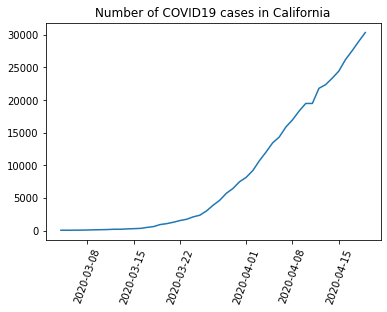

In [8]:
plt.title(f'Number of COVID19 cases in {cali.name}')
plt.plot(cali.dates, cali.cases, label=cali.code)
plt.xticks(rotation=70)

### United States of America
If we want to have an overview on all the available data, we just need to call the `RegionData.from_ctp` function with `'US'` as argument or without passing any, in which case the default value `'ALL'` is used.

In [0]:
data_all = RegionData.from_ctp()
data_us = RegionData.from_ctp('US')

In [10]:
print('Dates coincide: ', np.all(data_all.dates == data_us.dates))
print('Cases coincide: ', np.all(data_all.cases == data_us.cases))

Dates coincide:  True
Cases coincide:  True


In [11]:
print("Calling `RegionData.from_ctp()`")
print(data_all)
print("\nCalling `RegionData.from_ctp('US')`")
print(data_us)

Calling `RegionData.from_ctp()`
Region: United States of America, US
N. data points: 52.
Dates from 2020-02-28 00:00:00 to 2020-04-19 00:00:00.
Cases at 2020-04-19 00:00:00: 749203.

Calling `RegionData.from_ctp('US')`
Region: United States of America, US
N. data points: 52.
Dates from 2020-02-28 00:00:00 to 2020-04-19 00:00:00.
Cases at 2020-04-19 00:00:00: 749203.


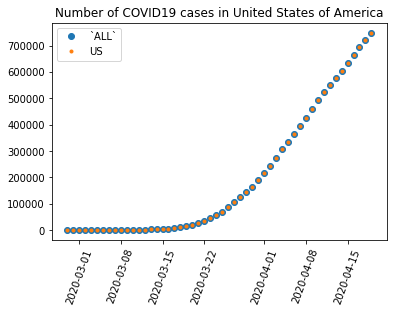

In [12]:
plt.title(f'Number of COVID19 cases in {data_all.name}')
plt.plot(data_all.dates, data_all.cases, 'o', label='`ALL`')
plt.plot(data_us.dates, data_us.cases, '.', label=data_us.code)
plt.xticks(rotation=70)
plt.legend()